# PyLFPPL: Introduction

Python LFPPL is a probabilistic programming language that is built for enabling one to perform inference in probabilistic programs that require gradient based inference algorithms. As `if-else` statements within probabilistic programs that use gradient based inference, take on two different forms. On one hand hand `if-else` have the usual programmer interpretation, but on the other, when random variables are placed inside of the predicate, or the body of an `if-else` expression, then we must treat those variables with care as discontinuities arise at point of indecision. We must ensure that at this indecision boundary the discontinuity, with respect to space it is in and the measure imposed on it, has a measure of zero. 

Our framework was built to ensure that certain criteria in the compiled output of a directed acyclic graphical model are met. The language is extensible enough for one to add their own custom built potentials; which could be either log joint densities or loss functions, within the framework. There is a higher layer inference framework that takes advantage of PyLFPPL called [pyfo](https://github.com/bradleygramhansen/pyfo), we are actively developing this. The corresponding paper is called [A Low-level Probabilistic Programming Language for Non-Differentiable Models](toadd). 

In this walk-through we shall go through the basics of how to write a model and how to compile the model. In the following walk-through we shall show how to use custom density functions, how add other distributions within the framework and how to take advantage of the translation rules that are embedded within the language. 

## PyLFPPL imports

In [1]:
%matplotlib inline
from pyppl import compile_model 
from pyppl.utils.core import create_network_graph, display_graph


## A statistical model with basic control-flow

For fun, let us add some contextual data: Whether or not Alice decides to go to space is highly dependent upon the number of points Alice collects, which is dependent upon a draw from a centered normal distribution, $x_1$. If she draws a number greater than 0, then we observe that Alice gets 1.5 points and the likelihood she goes to space, given the 1.5 points, is distributed by $\mathcal{N}(1.5~|~x_1,1)$. However, if she draws a number less than or equal to 0, then her likelihood is quite different. She gains 1 point, but the likelihood that the distribution is centered around 1, is dependent upon a random draw from a categorical distribution that returns a 0 with probability 0.1, 1 with probability 0.2, and 2 with probability 0.7. If we find that the value of the $x_1$ after the inference is greater than zero, then Alice goes to space, else she stays on Earth :-(


$$ x_1 \sim \mathcal{N}(0,1) $$
$$ x_2 \sim \mathcal{Cat}(0.1, 0.2, 0.7) $$
we observe our data ("points")
$$y_1 = 1.5 $$
$$y_2 = 1 $$

likelihood terms
$$ y_1 = 1.5~|~x_1 = \mathcal{N}(y_1~|~x_1,~1) $$
$$ y_2 = 1~|~x_2 = \mathcal{N}(y_2~|~x_2,~1) $$


In [2]:
model_if_clojure="""
(let [x1 (sample (normal [0 0 0] [1 1 1]))
      x2 (sample (categorical [0.1 0.2 0.7]))
      y1 [1.5 1.5 1.5]
      y2 [1 1 1] ]
  (if (> x1 0)
    (observe (normal x1 [1 1 1]) y1)
    (observe (normal x2 [1 1 1]) y2))
  [x1 x2])
"""


compiled_clojure = compile_model(model_if_clojure, language='clojure')


The compiler takes the above code and transforms it into a model class, from which the user can manipulate the program and interface with an inference engine. 

As can be seen above, the language consists of some special syntax, one being 
<font color='red'>sample</font>`(<distribution_name>(param1, param2m, ...))`

which generates the `priors` for the variables of interest, and the second being 
<font color='blue'>observe</font>`(<distribution name>(param1, param2, ...), <observation/data>)` 

which generates the likelihood given the observed data. The definitions given here are for when writing models in `python`, but examples of what the statements look like in `clojure` is given in the example above. 

Finally, `if`-expressions, whilst on the surface look like usual `if`-statements, are interpreted in a special way in `PyLFPPL`. If the predicate, in the example above this is `(> x1 0)`, contains any <font color='red'>sampled</font> variables, then within `PyLFPPL` a specific key-value pair is generated for that `if`-statement, so that those variables can be controlled in a special way. 

This is especially important when using gradient based inference algorithms, as the conditions within the predicates can create **measure zero** discontinuities. When using algorithms such as Hamiltonian Monte Carlo (HMC) for performing inference in models that are of a low dimensionality with a suitably low number of discontinuities, one may not notice a difference in the outcome of the inference result. If they have the ground truth available. However, using HMC on such models is completely and utterly statistically wrong. But the HMC algorithm for such a model would run without hindrance. 

This is dangerous for two reasons. One, If probabilistic programming languages and systems are supposed to deal with these subtleties whilst letting the modeller focus on modelling, then we are letting down a large group of the target users, who may not truly understand these subtleties. Two, the use of gradient based inference with control flow is poorly understood. Whilst point two, is re-iterating point one to some extent, it is important to understand, that a lack of understanding about a particular inference technique is detrimental to the setup of the probabilistic programming language and system. This is one of the reasons behind `PyLFPPL`, a simple language with inbuilt constraints to avoid these issue, yet is flexible enough to be integrated into other probabilistic programming systems.  


Here is a print out of the model class for the above model:

In [3]:
print(compiled_clojure.code)

# 2019-03-04 13:13:02.409560
import torch.distributions as dist


class Model():

	def __init__(self, vertices: set, arcs: set, data: set, conditionals: set):
		super().__init__()
		self.vertices = vertices
		self.arcs = arcs
		self.data = data
		self.conditionals = conditionals
	
	def __repr__(self):
		V = '\n'.join(sorted([repr(v) for v in self.vertices]))
		A = ', '.join(['({}, {})'.format(u.name, v.name) for (u, v) in self.arcs]) if len(self.arcs) > 0 else '  -'
		C = '\n'.join(sorted([repr(v) for v in self.conditionals])) if len(self.conditionals) > 0 else '  -'
		D = '\n'.join([repr(u) for u in self.data]) if len(self.data) > 0 else '  -'
		graph = 'Vertices V:\n{V}\nArcs A:\n  {A}\n\nConditions C:\n{C}\n\nData D:\n{D}\n'.format(V=V, A=A, C=C, D=D)
		graph = '#Vertices: {}, #Arcs: {}\n'.format(len(self.vertices), len(self.arcs)) + graph
		return graph
	
	def gen_cond_bit_vector(self, state):
		result = 0
		for cond in self.conditionals:
			result = cond.update_bit_vector(state, r

We can change the models imported by changing the arguments in the `compile_model` function. By specification to our current application the compiler automatically imports `pytorch`. This can be easily removed by going into `ppl_graph_codegen.py` file and then removing the `if not has_dist` block. 

In [5]:
compile_clojure = compile_model(model_if_clojure, language='clojure',imports='import matplotlib as mpl \nimport numpy as np ')
print(compile_clojure.code)

# 2019-02-08 09:24:34.710042
import torch.distributions as dist
import matplotlib as mpl 
import numpy as np 

class Model():

	def __init__(self, vertices: set, arcs: set, data: set, conditionals: set):
		super().__init__()
		self.vertices = vertices
		self.arcs = arcs
		self.data = data
		self.conditionals = conditionals
	
	def __repr__(self):
		V = '\n'.join(sorted([repr(v) for v in self.vertices]))
		A = ', '.join(['({}, {})'.format(u.name, v.name) for (u, v) in self.arcs]) if len(self.arcs) > 0 else '  -'
		C = '\n'.join(sorted([repr(v) for v in self.conditionals])) if len(self.conditionals) > 0 else '  -'
		D = '\n'.join([repr(u) for u in self.data]) if len(self.data) > 0 else '  -'
		graph = 'Vertices V:\n{V}\nArcs A:\n  {A}\n\nConditions C:\n{C}\n\nData D:\n{D}\n'.format(V=V, A=A, C=C, D=D)
		graph = '#Vertices: {}, #Arcs: {}\n'.format(len(self.vertices), len(self.arcs)) + graph
		return graph
	
	def gen_cond_bit_vector(self, state):
		result = 0
		for cond in self.conditionals

## Printing the Graph G(V,E) of the statistical model. 

Each vertex of the graph is an object, with a set of attributes. These attributes describe the relationships between the vertex and other vertices. In addition to this, the attributes contain information about the observables and latent variables at each vertex.


In [5]:
print(compile_clojure)

#Vertices: 4, #Arcs: 2
Vertices V:
Vertex x30001 [Sample]
  Name:           x30001
  Ancestors:      
  Cond-Ancs.:     
  Dist-Args:      {'loc': '[0, 0, 0]', 'scale': '[1, 1, 1]'}
  Dist-Code:      dist.Normal([0, 0, 0], [1, 1, 1])
  Dist-Name:      Normal
  Dist-Type:      DistributionType.CONTINUOUS
  Sample-Size:    1
Vertex x30002 [Sample]
  Name:           x30002
  Ancestors:      
  Cond-Ancs.:     
  Dist-Args:      {'probs': '[0.1, 0.2, 0.7]'}
  Dist-Code:      dist.Categorical([0.1, 0.2, 0.7])
  Dist-Name:      Categorical
  Dist-Type:      DistributionType.DISCRETE
  Sample-Size:    1
Vertex y30004 [Observe]
  Name:           y30004
  Ancestors:      x30001
  Conditions:     cond_30003=True
  Cond-Ancs.:     x30001
  Cond-Nodes:     cond_30003
  Dist-Args:      {'loc': "state['x30001']", 'scale': '[1, 1, 1]'}
  Dist-Code:      dist.Normal(state['x30001'], [1, 1, 1])
  Dist-Name:      Normal
  Dist-Type:      DistributionType.CONTINUOUS
  Sample-Size:    1
  Observation:    

We can see from the graph that $x_2$ is only dependent on the observation $y_2$, whereas $x_1$ can be affected by both observations. 

##  An example of an independent Categorical model


In [6]:
model_categorical = """
(let[z (sample (categorical [0.7 0.15 0.15]))
    z1 (sample (categorical [0.1 0.5 0.4]))
    z2 (sample (categorical [0.2 0.2 0.6]))]
    z z1 z2)"""

In [7]:
compiled_clojure = compile_model(model_categorical, language='clojure')
# print(compiled_clojure.code)
vertices = compiled_clojure.vertices

### Plotting the depndence graph

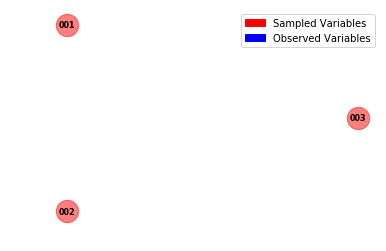

In [8]:
create_network_graph(vertices=vertices)
display_graph(vertices=vertices);

As you can see, in this model there are no dependencies between the different latent variables.

## A Hidden Markov Model

In a HMM the goal is to infer the hidden states. In doing so we aim to explain how our observations are produced, as the underlying assumption is that the hidden state directly affects the observation produced. This is a very short description, of a very powerful tool. See [here](http://mlg.eng.cam.ac.uk/zoubin/papers/ijprai.pdf) for more details on HMMs. 

In [9]:
model_hmm_clojure="""
(defn data [n]
  (let [points (vector 0.9 0.8 0.7 0.0 -0.025
                       5.0 2.0 0.1 0.0 0.13
                       0.45 6.0 0.2 0.3 -1.0 -1.0)]
    (get points n)))

;; Define the init, transition, and observation distributions
(defn get-init-params []
  (vector (/ 1. 3.) (/ 1. 3.) (/ 1. 3.)))

(defn get-trans-params [k]
  (nth (vector (vector 0.1  0.5  0.4 )
               (vector 0.2  0.2  0.6 )
               (vector 0.7 0.15 0.15 )) k))

(defn get-obs-dist [k]
  (nth (vector (normal -1. 1.)
               (normal  1. 1.)
               (normal  0. 1.)) k))

;; Function to step through HMM and sample latent state
(defn hmm-step [n states]
  (let [next-state (sample (categorical (get-trans-params (last states))))]
    (observe (get-obs-dist next-state) (data n))
    (conj states next-state)))

;; Loop through the data
(let [init-state (sample (categorical (get-init-params)))]
  (loop 16 (vector init-state) hmm-step))

"""

### Plotting the graphical model

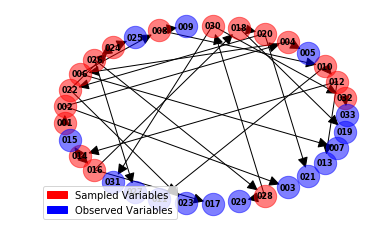

In [10]:
compiled_clojure = compile_model(model_hmm_clojure, language='clojure')
vertices = compiled_clojure.vertices
create_network_graph(vertices=vertices)
display_graph(vertices=vertices);

# PyLFPPL for python based models

PyLFPPLs design allows one to use it with many different languages, we so far have built an interface for both `python` and `clojure` code. 
It is also important to note that the number of distributions one can add to `PyLFPPL` is boundless, as we will show in future walk-throughs. 

## Bayesian linear regression model

The aim of inference in this model is to infer the equation of the line $ x = y*s + b$ (this is written to match the notation below. In general one would see his written as $y = mx +c$).

$$slope \sim \mathcal{N}(0, 10) $$
$$bias \sim \mathcal{N}(0, 10) $$

Observations
$$y = [(1.,2.), (2.1,3.9), (3.,5.3)] $$
Constructing the equation of the predicted curve
$$x_n = slope \times y[1,n] + bias$$
The likelihood
$$y = y[2,n]~|~x_n = \mathcal{N}(y[2,n]~|~x_n,~\mathbf{I}) $$   

## The Python SPPL code

In [11]:

model_lr_python = """
import torch
slope= sample(normal(torch.zeros(1), torch.ones(10.0)))
bias= sample(normal(torch.zeros(1), torch.tensor(10.0)))
y= torch.tensor([[1.0, 2.1], [2.0, 3.9], [3.0, 5.3]])
def f(data,slope,bias,i):
    return slope*data[0,i] + bias
for i in range(3):
    observe(normal(slope*y[0,i] + bias , torch.ones(len(f(y[0,i],slope,bias,i)))),y[1,i])

[slope, bias]
"""


In [12]:
compiled_python = compile_model(model_lr_python, language='python')

## The Graph


In [13]:
print(compiled_python)

#Vertices: 5, #Arcs: 6
Vertices V:
Vertex x30001 [Sample]
  Name:           x30001
  Ancestors:      
  Cond-Ancs.:     
  Dist-Args:      {'loc': 'torch.zeros(1)', 'scale': 'torch.ones(10.0)'}
  Dist-Code:      dist.Normal(torch.zeros(1), torch.ones(10.0))
  Dist-Name:      Normal
  Dist-Type:      DistributionType.CONTINUOUS
  Sample-Size:    1
  Orig. Name:     slope
Vertex x30002 [Sample]
  Name:           x30002
  Ancestors:      
  Cond-Ancs.:     
  Dist-Args:      {'loc': 'torch.zeros(1)', 'scale': 'torch.tensor(10.0)'}
  Dist-Code:      dist.Normal(torch.zeros(1), torch.tensor(10.0))
  Dist-Name:      Normal
  Dist-Type:      DistributionType.CONTINUOUS
  Sample-Size:    1
  Orig. Name:     bias
Vertex y30003 [Observe]
  Name:           y30003
  Ancestors:      x30001, x30002
  Conditions:     
  Cond-Ancs.:     
  Cond-Nodes:     
  Dist-Args:      {'loc': "((state['x30001'] * torch.tensor([[1.0, 2.1], [2.0, 3.9], [3.0, 5.3]])[[0, 0]]) + state['x30002'])", 'scale': "torch.one

In [14]:
print(compiled_python.code)

# 2019-02-08 09:25:10.920016
import torch.distributions as dist
import torch

class Model():

	def __init__(self, vertices: set, arcs: set, data: set, conditionals: set):
		super().__init__()
		self.vertices = vertices
		self.arcs = arcs
		self.data = data
		self.conditionals = conditionals
	
	def __repr__(self):
		V = '\n'.join(sorted([repr(v) for v in self.vertices]))
		A = ', '.join(['({}, {})'.format(u.name, v.name) for (u, v) in self.arcs]) if len(self.arcs) > 0 else '  -'
		C = '\n'.join(sorted([repr(v) for v in self.conditionals])) if len(self.conditionals) > 0 else '  -'
		D = '\n'.join([repr(u) for u in self.data]) if len(self.data) > 0 else '  -'
		graph = 'Vertices V:\n{V}\nArcs A:\n  {A}\n\nConditions C:\n{C}\n\nData D:\n{D}\n'.format(V=V, A=A, C=C, D=D)
		graph = '#Vertices: {}, #Arcs: {}\n'.format(len(self.vertices), len(self.arcs)) + graph
		return graph
	
	def gen_cond_bit_vector(self, state):
		result = 0
		for cond in self.conditionals:
			result = cond.update_bit_vec

## The dependency graph

With `python` models we can plot the user defined label names. 

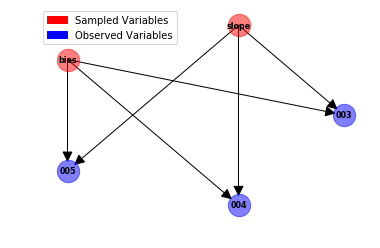

In [15]:
vertices = compiled_python.vertices
create_network_graph(vertices=vertices)
display_graph(vertices=vertices);

# Models in pure python
We don't need to import `torch`, we can actually write models in pure python, for example:

In [16]:
model_purepython="""
mean= sample(poisson(3))
x= sample(gamma(mean,1))
y= 10
observe(normal(x,5), y)
"""

In [17]:
compiled_python = compile_model(model_purepython, language='python')

## An Example of the Graph G(V,E)

In [18]:
print(compiled_python)

#Vertices: 3, #Arcs: 2
Vertices V:
Vertex x30001 [Sample]
  Name:           x30001
  Ancestors:      
  Cond-Ancs.:     
  Dist-Args:      {'rate': '3'}
  Dist-Code:      dist.Poisson(3)
  Dist-Name:      Poisson
  Dist-Type:      DistributionType.DISCRETE
  Sample-Size:    1
  Orig. Name:     mean
Vertex x30002 [Sample]
  Name:           x30002
  Ancestors:      x30001
  Cond-Ancs.:     
  Dist-Args:      {'alpha': "state['x30001']", 'beta': '1'}
  Dist-Code:      dist.Gamma(state['x30001'], 1)
  Dist-Name:      Gamma
  Dist-Type:      DistributionType.CONTINUOUS
  Sample-Size:    1
  Orig. Name:     x
Vertex y30003 [Observe]
  Name:           y30003
  Ancestors:      x30002
  Conditions:     
  Cond-Ancs.:     
  Cond-Nodes:     
  Dist-Args:      {'loc': "state['x30002']", 'scale': '5'}
  Dist-Code:      dist.Normal(state['x30002'], 5)
  Dist-Name:      Normal
  Dist-Type:      DistributionType.CONTINUOUS
  Sample-Size:    1
  Observation:    10
Arcs A:
  (x30002, y30003), (x30001, 

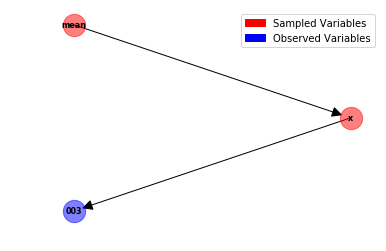

In [19]:
vertices = compiled_python.vertices
create_network_graph(vertices=vertices)
display_graph(vertices=vertices);

## Gaussian Mixture model

In this model the goal of the inference procedure is to infer the unknown means that describe the observations. Gaussian mixtures assume that the data can be modelled by a collection of Gaussian distributions (of course this is by no means always true). 

Also note that by importing ```torch``` we take advantage of the torch distribution library, hence we can wrap our system around the discrete primatives, such as ```categorical``` in  ```PyTorch```. Notice that LF-PPL still manages to correctly extract the variables with which the densitiy is discontinuous with respect too.    

In [20]:
model_gmm2 = """
import torch

means= 2
samples= 10
y= [-2.0, -2.5, -1.7, -1.9, -2.2, 1.5, 2.2, 3.0, 1.2, 2.8,-1.7, -1.3,  3.2,  0.8, -0.9, 0.3, 1.4, 2.1, 0.8, 1.9] 
ys= torch.tensor([y])
pi= torch.tensor(0.5*torch.ones(samples,means))
mus= sample(normal(torch.zeros(means,1), 2*torch.ones(means,1)))

zn= sample(categorical(pi), sample_size=2)

for i in range(samples):
    index = (zn == i).nonzero()
    observe(normal(mus[i]*torch.ones(len(index),1), 2*torch.ones(len(index),1)), ys[index])
"""

In [21]:

compiled_python = compile_model(model_gmm2, language='python')

## The code output

In [22]:
print(compiled_python.code)

# 2019-02-08 09:25:22.891927
import torch.distributions as dist
import torch

class Model():

	def __init__(self, vertices: set, arcs: set, data: set, conditionals: set):
		super().__init__()
		self.vertices = vertices
		self.arcs = arcs
		self.data = data
		self.conditionals = conditionals
	
	def __repr__(self):
		V = '\n'.join(sorted([repr(v) for v in self.vertices]))
		A = ', '.join(['({}, {})'.format(u.name, v.name) for (u, v) in self.arcs]) if len(self.arcs) > 0 else '  -'
		C = '\n'.join(sorted([repr(v) for v in self.conditionals])) if len(self.conditionals) > 0 else '  -'
		D = '\n'.join([repr(u) for u in self.data]) if len(self.data) > 0 else '  -'
		graph = 'Vertices V:\n{V}\nArcs A:\n  {A}\n\nConditions C:\n{C}\n\nData D:\n{D}\n'.format(V=V, A=A, C=C, D=D)
		graph = '#Vertices: {}, #Arcs: {}\n'.format(len(self.vertices), len(self.arcs)) + graph
		return graph
	
	def gen_cond_bit_vector(self, state):
		result = 0
		for cond in self.conditionals:
			result = cond.update_bit_vec

## The dependency graph

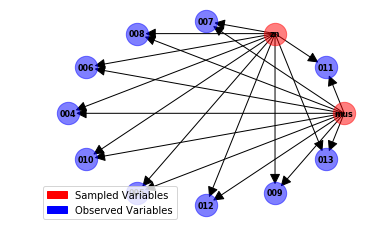

In [23]:
vertices = compiled_python.vertices
create_network_graph(vertices=vertices)
display_graph(vertices=vertices);

## Coal Mining model

This model is popular change point detection model in the statistics community. The goal of the model is to infer, whether or not improvements in technology and safety had an impact on reducing the number of coal mining related deaths. See [here](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=7&ved=0ahUKEwibzpmXxeTbAhVIPhQKHRxGCVEQFghFMAY&url=https%3A%2F%2Fwiki.helsinki.fi%2Fdownload%2Fattachments%2F48865343%2FWB.pdf&usg=AOvVaw0Vx-U9LuQU4j9W-dnLpZgr) for more details.  


In [27]:
model_coal_mining="""
e= sample(exponential(1))
l= sample(exponential(1))
T= 10
s= sample(uniform(0,10))
y= [4,5,4,1,0,4,3,4,0,6,3,3,4,0,2,6,3,3,5,4,5,3,1,4,4,1,5,5,
      3,4,2,5,2,2,3,4,2,1,3,2,1,1,1,1,1,3,0,0,1,0,1,1,0,0,3,1,
      0,3,2,2,0,1,1,1,0,1,0,1,0,0,0,2,1,0,0,0,1,1,0,2,2,3,1,1,
      2,1,1,1,1,2,4,2,0,0,0,1,4,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0]
for i in range(T-1):
    if i+1 < s:
        observe(exponential(e), y[i])
    elif i == s:
        observe(exponential(1), y[i])
    else:
        observe(exponential(2), y[i])
[e,l,s]
"""


In [28]:
compiled_python = compile_model(model_coal_mining, language='python')

In [29]:
print(compiled_python.code)

# 2019-02-08 09:26:05.051650
import torch.distributions as dist


class Model():

	def __init__(self, vertices: set, arcs: set, data: set, conditionals: set):
		super().__init__()
		self.vertices = vertices
		self.arcs = arcs
		self.data = data
		self.conditionals = conditionals
	
	def __repr__(self):
		V = '\n'.join(sorted([repr(v) for v in self.vertices]))
		A = ', '.join(['({}, {})'.format(u.name, v.name) for (u, v) in self.arcs]) if len(self.arcs) > 0 else '  -'
		C = '\n'.join(sorted([repr(v) for v in self.conditionals])) if len(self.conditionals) > 0 else '  -'
		D = '\n'.join([repr(u) for u in self.data]) if len(self.data) > 0 else '  -'
		graph = 'Vertices V:\n{V}\nArcs A:\n  {A}\n\nConditions C:\n{C}\n\nData D:\n{D}\n'.format(V=V, A=A, C=C, D=D)
		graph = '#Vertices: {}, #Arcs: {}\n'.format(len(self.vertices), len(self.arcs)) + graph
		return graph
	
	def gen_cond_bit_vector(self, state):
		result = 0
		for cond in self.conditionals:
			result = cond.update_bit_vector(state, r

## The dependency graph

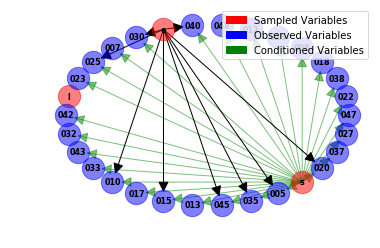

In [30]:
vertices = compiled_python.vertices
create_network_graph(vertices=vertices)
display_graph(vertices=vertices);

## Other types of analytic functions

In [6]:
model_purepython="""
mean= sample(Exp(3))
x= sample(gamma(mean,1))
y= 10
observe(Log(x*x+1), y)
"""
compiled_python = compile_model(model_purepython, language='python')

print(compiled_python.code)

# 2019-02-10 15:25:33.749876
import torch.distributions as dist


class Model():

	def __init__(self, vertices: set, arcs: set, data: set, conditionals: set):
		super().__init__()
		self.vertices = vertices
		self.arcs = arcs
		self.data = data
		self.conditionals = conditionals
	
	def __repr__(self):
		V = '\n'.join(sorted([repr(v) for v in self.vertices]))
		A = ', '.join(['({}, {})'.format(u.name, v.name) for (u, v) in self.arcs]) if len(self.arcs) > 0 else '  -'
		C = '\n'.join(sorted([repr(v) for v in self.conditionals])) if len(self.conditionals) > 0 else '  -'
		D = '\n'.join([repr(u) for u in self.data]) if len(self.data) > 0 else '  -'
		graph = 'Vertices V:\n{V}\nArcs A:\n  {A}\n\nConditions C:\n{C}\n\nData D:\n{D}\n'.format(V=V, A=A, C=C, D=D)
		graph = '#Vertices: {}, #Arcs: {}\n'.format(len(self.vertices), len(self.arcs)) + graph
		return graph
	
	def gen_cond_bit_vector(self, state):
		result = 0
		for cond in self.conditionals:
			result = cond.update_bit_vector(state, r

I would like to thank [Andrea Patanè](http://www.cs.ox.ac.uk/people/andrea.patane/), [Sasha Salter](http://ori.ox.ac.uk/mrg_people/sasha-salter/) and Saeid Naderiparizi for proof reading the post.

## Using factor

In the following examples we demonstrate how to use ```factor``` and what happens when dealing with models that contain zero-density. 

In [3]:
model_rrhmc_clojure="""
(let [x (sample (uniform -6 6))
       absx (max x (- x))
       A 0.1
       y 0
       z (- (sqrt (* x (* A x))))]
 (if (< (- absx 3) 0)
     (observe (factor z) y)
     (observe (factor(- z 1)) y))
 x)
"""

model_rrhmc_python= """
import torch
x = sample(uniform(-6,6))
absx = max(x, -x)
A = 0.1
z = -torch.sqrt(x*A*x)
if absx-3 < 0:
    observe(factor(z),None)
    observe(factor(z-1),None)
"""
compiled_clojure = compile_model(model_rrhmc_clojure, language='clojure')
compiled_python = compile_model(model_rrhmc_python, language='python')

In [4]:
print(compiled_python)
print(compiled_python.code)

#Vertices: 3, #Arcs: 2
Vertices V:
Vertex x30001 [Sample]
  Name:           x30001
  Ancestors:      
  Cond-Ancs.:     
  Dist-Args:      {'low': '-6', 'high': '6'}
  Dist-Code:      dist.Uniform(-6, 6)
  Dist-Name:      Uniform
  Dist-Type:      DistributionType.CONTINUOUS
  Sample-Size:    1
  Orig. Name:     x
Vertex y30003 [Observe]
  Name:           y30003
  Ancestors:      x30001
  Conditions:     cond_30002=True
  Cond-Ancs.:     x30001
  Cond-Nodes:     cond_30002
  Dist-Args:      {'log_p': "-torch.sqrt(((state['x30001'] * 0.1) * state['x30001']))"}
  Dist-Code:      dist.factor(-torch.sqrt(((state['x30001'] * 0.1) * state['x30001'])))
  Dist-Name:      factor
  Dist-Type:      DistributionType.UNDEFINED
  Sample-Size:    1
  Observation:    None
Vertex y30004 [Observe]
  Name:           y30004
  Ancestors:      x30001
  Conditions:     cond_30002=True
  Cond-Ancs.:     x30001
  Cond-Nodes:     cond_30002
  Dist-Args:      {'log_p': "(-torch.sqrt(((state['x30001'] * 0.1) * st

In [12]:
import torch.distributions as dist
import torch

# In practice the factor statement will be a class, pre-defined
# within your choosen distribution library. This may require you 
# to add a simple class like the one provided below.
class factor:
    def __init__(self,log_p):
        self.log_p = log_p
    
    def log_prob(self,value):
    # all entries to the factor statement are just values
    # as the factor statement itself is not a function and thus does not evaluate. 
    # It can only return the following. Value here is discarded as factor does not
    # process values.
        return torch.exp(self.log_p)

# The following functions are contained within the model class output. 
# We could have easily written something like the following, if factor exists inside of
# your distibution classes:

# model = compile_python
# print(model.gen_prior_samples())
def gen_log_prob(state):
    try:
        log_prob = 0
        dst_ = dist.Uniform(low=-6, high=6)
        log_prob = log_prob + dst_.log_prob(state['x30001'])
        state['cond_30002'] = ((max(state['x30001'], -state['x30001']) + -3) < 0)
        dst_ = factor(log_p=-torch.sqrt(((state['x30001'] * 0.1) * state['x30001'])))
        if state['cond_30002']:
            log_prob = log_prob + dst_.log_prob(state['y30003'])
        dst_ = factor(log_p=(-torch.sqrt(((state['x30001'] * 0.1) * state['x30001'])) + -1))
        if state['cond_30002']:
            log_prob = log_prob + dst_.log_prob(state['y30004'])
        return log_prob
    except(RuntimeError,ValueError) as e:
        print('****Warning: Target density is ill-defined****')
def gen_prior_samples():
		state = {}
		dst_ = dist.Uniform(low=-6, high=6)
		state['x30001'] = dst_.sample()
		state['cond_30002'] = ((max(state['x30001'], -state['x30001']) + -3) < 0)
		dst_ = factor(log_p=-torch.sqrt(((state['x30001'] * 0.1) * state['x30001'])))
		state['y30003'] = None
		dst_ = factor(log_p=(-torch.sqrt(((state['x30001'] * 0.1) * state['x30001'])) + -1))
		state['y30004'] = None
		return state

# Generating the state from the compilation target. 
state  = gen_prior_samples()
print(state)
print(gen_log_prob(state))


{'x30001': tensor(-4.3561), 'cond_30002': tensor(0, dtype=torch.uint8), 'y30003': None, 'y30004': None}
tensor(-2.4849)


It is **important** to note that `factor` statements cannot be placed inside of `sample` statements. For example, consider the following model from above, slightly adapted:

In [8]:
model_rrhmc_python= """
import torch
x = sample(uniform(-6,6))
x_not_allowed = sample(factor(6))
absx = max(x, -x)
A = 0.1
z = -torch.sqrt(x*A*x)
if absx-3 < 0:
    observe(factor(z),None)
    observe(factor(z-1),None)
"""
compiled_python = compile_model(model_rrhmc_python, language='python')

/Users/bradley/Documents/Projects/Pyfo_project/PyLFPPL/pyppl/backend/ppl_graph_generator.py:153: UserWarning: ********** Model is not valid **********
  self.define(node.name, self.visit(node.value))
/Users/bradley/Documents/Projects/Pyfo_project/PyLFPPL/pyppl/backend/ppl_graph_generator.py:153: UserWarning: ********** factor statements cannot be placed within sample statements  **********
  self.define(node.name, self.visit(node.value))


SystemExit: 1

/Users/bradley/miniconda3/envs/pysppl/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2969: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


To understand why this is so, see Chapter 4 of Tom Rainforth's thesis: [here](https://www.researchgate.net/profile/Tom_Rainforth/publication/324923515_Automating_Inference_Learning_and_Design_using_Probabilistic_Programming/links/5aeb84ce0f7e9b01d3e05b8d/Automating-Inference-Learning-and-Design-using-Probabilistic-Programming.pdf)  or the following paper by Sam Stanton, Hongseok Yang et al. for even greater technical details: [here](https://arxiv.org/pdf/1601.04943.pdf)

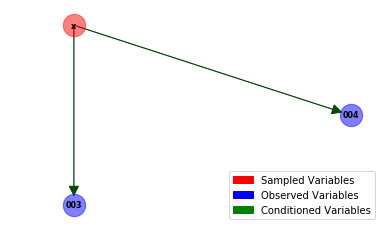

There are 1 latent variables
['x30001']
Unique name in compiler: x30001 User defined name:  x
Printing the observable name: y30004 and value: None
Printing the observable name: y30003 and value: None
{Condition
  Name:         cond_30002
  Ancestors:    x30001
  Condition:    ((max(state['x30001'], -state['x30001']) + -3) < 0)
  Function:     (max(state['x30001'], -state['x30001']) + -3)
  Op:           <}


In [9]:
vertices = compiled_python.vertices
create_network_graph(vertices=vertices)
display_graph(vertices=vertices);

# a list of all latent vars
all_sampled_vars = compiled_python.get_vars()

_number_of_latents = len(all_sampled_vars)
print('There are {} latent variables'.format(_number_of_latents))

print(all_sampled_vars)
_names = dict(
    [(vertex.name, vertex.original_name) for vertex in vertices if vertex.name in all_sampled_vars])# distribution arguments and names


for key in _names:
    print('Unique name in compiler: {0} User defined name:  {1}'.format(key, _names[key]))
    
    
observables = dict([(vertex.name, vertex.observation) for vertex in vertices if vertex.is_observed])
for key in observables:
    print('Printing the observable name: {0} and value: {1}'.format(key, observables[key]))

_cond_bools = None if len(compiled_python.gen_if_vars()) == 0 else compiled_python.gen_cond_vars()
print(compiled_python.get_conditions())

A very simple example of how factor could be written in your probabilistic programming system is provided below. 

In [53]:
def factor(log_p=None):
    import math
    return math.exp(log_p)

## Density 0 Model

In this model the ```Model.gen_logprob()``` will have to evaluate `log(0) =` $\infty$, which implies the `log_prob = ` $\infty$. 
This would enable the user to discard, or record, if necessary, such samples.  


In [10]:
model_densityzero_python= """
import torch
x = sample(normal(2,0))
y = 1
if x < -0.5:
    observe(normal(-2,1),y)
elif x < 0.5:
    observe(factor(0),y)
else:
    observe(normal(2,1),y)
"""
compile_python = compile_model(model_densityzero_python, language="python")

# 2019-03-04 13:25:49.228324
import torch.distributions as dist
import torch

class Model():

	def __init__(self, vertices: set, arcs: set, data: set, conditionals: set):
		super().__init__()
		self.vertices = vertices
		self.arcs = arcs
		self.data = data
		self.conditionals = conditionals
	
	def __repr__(self):
		V = '\n'.join(sorted([repr(v) for v in self.vertices]))
		A = ', '.join(['({}, {})'.format(u.name, v.name) for (u, v) in self.arcs]) if len(self.arcs) > 0 else '  -'
		C = '\n'.join(sorted([repr(v) for v in self.conditionals])) if len(self.conditionals) > 0 else '  -'
		D = '\n'.join([repr(u) for u in self.data]) if len(self.data) > 0 else '  -'
		graph = 'Vertices V:\n{V}\nArcs A:\n  {A}\n\nConditions C:\n{C}\n\nData D:\n{D}\n'.format(V=V, A=A, C=C, D=D)
		graph = '#Vertices: {}, #Arcs: {}\n'.format(len(self.vertices), len(self.arcs)) + graph
		return graph
	
	def gen_cond_bit_vector(self, state):
		result = 0
		for cond in self.conditionals:
			result = cond.update_bit_vec

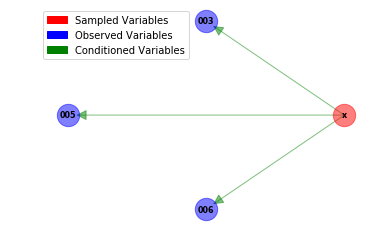

In [11]:
print(compile_python.code)
vertices = compile_python.vertices
create_network_graph(vertices=vertices)
display_graph(vertices=vertices);